# Representational Rényi Heterogeneity: Supplemental Code for Analysis of Convolutional Variational Autoencoder on MNIST Data 

**Abraham Nunes, Martin Alda, Timothy Bardouille, and Thomas Trappenberg**

*Dalhousie University, Halifax, Nova Scotia, Canada*

## Representational Rényi Heterogeneity under a Convolutional Variational Autoencoder

The deep learning aspect of this analysis is largely based on code provided by the Smart Geometry Processing Group at University College London: https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb



In [1]:
import os
import urllib
import numpy as np 
import scipy.stats as ss
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torchvision.utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
import matplotlib.pyplot as plt
use_gpu = True

!pip3 install --ignore-installed git+https://github.com/abrahamnunes/diversity.git
import diversity as div

  Cloning https://github.com/abrahamnunes/diversity.git to /tmp/pip-req-build-8etdyqon
  Running command git clone -q https://github.com/abrahamnunes/diversity.git /tmp/pip-req-build-8etdyqon
  Created wheel for diversity: filename=diversity-0.1.0-py2.py3-none-any.whl size=13960 sha256=d835b259e208c172d7d7173461dea78068fa864cdb11e81a5d775e725c0cb2ab
  Stored in directory: /tmp/pip-ephem-wheel-cache-8r_6i4qh/wheels/1d/47/87/07b500222b06eb0aa9fe39994667ff1b33fb707bcaa182b262
Successfully built diversity


In [0]:
# Registering the "turbo" colormap
turbo_data = np.array([[0.18995,0.07176,0.23217],[0.19483,0.08339,0.26149],[0.19956,0.09498,0.29024],[0.20415,0.10652,0.31844],[0.20860,0.11802,0.34607],[0.21291,0.12947,0.37314],[0.21708,0.14087,0.39964],[0.22111,0.15223,0.42558],[0.22500,0.16354,0.45096],[0.22875,0.17481,0.47578],[0.23236,0.18603,0.50004],[0.23582,0.19720,0.52373],[0.23915,0.20833,0.54686],[0.24234,0.21941,0.56942],[0.24539,0.23044,0.59142],[0.24830,0.24143,0.61286],[0.25107,0.25237,0.63374],[0.25369,0.26327,0.65406],[0.25618,0.27412,0.67381],[0.25853,0.28492,0.69300],[0.26074,0.29568,0.71162],[0.26280,0.30639,0.72968],[0.26473,0.31706,0.74718],[0.26652,0.32768,0.76412],[0.26816,0.33825,0.78050],[0.26967,0.34878,0.79631],[0.27103,0.35926,0.81156],[0.27226,0.36970,0.82624],[0.27334,0.38008,0.84037],[0.27429,0.39043,0.85393],[0.27509,0.40072,0.86692],[0.27576,0.41097,0.87936],[0.27628,0.42118,0.89123],[0.27667,0.43134,0.90254],[0.27691,0.44145,0.91328],[0.27701,0.45152,0.92347],[0.27698,0.46153,0.93309],[0.27680,0.47151,0.94214],[0.27648,0.48144,0.95064],[0.27603,0.49132,0.95857],[0.27543,0.50115,0.96594],[0.27469,0.51094,0.97275],[0.27381,0.52069,0.97899],[0.27273,0.53040,0.98461],[0.27106,0.54015,0.98930],[0.26878,0.54995,0.99303],[0.26592,0.55979,0.99583],[0.26252,0.56967,0.99773],[0.25862,0.57958,0.99876],[0.25425,0.58950,0.99896],[0.24946,0.59943,0.99835],[0.24427,0.60937,0.99697],[0.23874,0.61931,0.99485],[0.23288,0.62923,0.99202],[0.22676,0.63913,0.98851],[0.22039,0.64901,0.98436],[0.21382,0.65886,0.97959],[0.20708,0.66866,0.97423],[0.20021,0.67842,0.96833],[0.19326,0.68812,0.96190],[0.18625,0.69775,0.95498],[0.17923,0.70732,0.94761],[0.17223,0.71680,0.93981],[0.16529,0.72620,0.93161],[0.15844,0.73551,0.92305],[0.15173,0.74472,0.91416],[0.14519,0.75381,0.90496],[0.13886,0.76279,0.89550],[0.13278,0.77165,0.88580],[0.12698,0.78037,0.87590],[0.12151,0.78896,0.86581],[0.11639,0.79740,0.85559],[0.11167,0.80569,0.84525],[0.10738,0.81381,0.83484],[0.10357,0.82177,0.82437],[0.10026,0.82955,0.81389],[0.09750,0.83714,0.80342],[0.09532,0.84455,0.79299],[0.09377,0.85175,0.78264],[0.09287,0.85875,0.77240],[0.09267,0.86554,0.76230],[0.09320,0.87211,0.75237],[0.09451,0.87844,0.74265],[0.09662,0.88454,0.73316],[0.09958,0.89040,0.72393],[0.10342,0.89600,0.71500],[0.10815,0.90142,0.70599],[0.11374,0.90673,0.69651],[0.12014,0.91193,0.68660],[0.12733,0.91701,0.67627],[0.13526,0.92197,0.66556],[0.14391,0.92680,0.65448],[0.15323,0.93151,0.64308],[0.16319,0.93609,0.63137],[0.17377,0.94053,0.61938],[0.18491,0.94484,0.60713],[0.19659,0.94901,0.59466],[0.20877,0.95304,0.58199],[0.22142,0.95692,0.56914],[0.23449,0.96065,0.55614],[0.24797,0.96423,0.54303],[0.26180,0.96765,0.52981],[0.27597,0.97092,0.51653],[0.29042,0.97403,0.50321],[0.30513,0.97697,0.48987],[0.32006,0.97974,0.47654],[0.33517,0.98234,0.46325],[0.35043,0.98477,0.45002],[0.36581,0.98702,0.43688],[0.38127,0.98909,0.42386],[0.39678,0.99098,0.41098],[0.41229,0.99268,0.39826],[0.42778,0.99419,0.38575],[0.44321,0.99551,0.37345],[0.45854,0.99663,0.36140],[0.47375,0.99755,0.34963],[0.48879,0.99828,0.33816],[0.50362,0.99879,0.32701],[0.51822,0.99910,0.31622],[0.53255,0.99919,0.30581],[0.54658,0.99907,0.29581],[0.56026,0.99873,0.28623],[0.57357,0.99817,0.27712],[0.58646,0.99739,0.26849],[0.59891,0.99638,0.26038],[0.61088,0.99514,0.25280],[0.62233,0.99366,0.24579],[0.63323,0.99195,0.23937],[0.64362,0.98999,0.23356],[0.65394,0.98775,0.22835],[0.66428,0.98524,0.22370],[0.67462,0.98246,0.21960],[0.68494,0.97941,0.21602],[0.69525,0.97610,0.21294],[0.70553,0.97255,0.21032],[0.71577,0.96875,0.20815],[0.72596,0.96470,0.20640],[0.73610,0.96043,0.20504],[0.74617,0.95593,0.20406],[0.75617,0.95121,0.20343],[0.76608,0.94627,0.20311],[0.77591,0.94113,0.20310],[0.78563,0.93579,0.20336],[0.79524,0.93025,0.20386],[0.80473,0.92452,0.20459],[0.81410,0.91861,0.20552],[0.82333,0.91253,0.20663],[0.83241,0.90627,0.20788],[0.84133,0.89986,0.20926],[0.85010,0.89328,0.21074],[0.85868,0.88655,0.21230],[0.86709,0.87968,0.21391],[0.87530,0.87267,0.21555],[0.88331,0.86553,0.21719],[0.89112,0.85826,0.21880],[0.89870,0.85087,0.22038],[0.90605,0.84337,0.22188],[0.91317,0.83576,0.22328],[0.92004,0.82806,0.22456],[0.92666,0.82025,0.22570],[0.93301,0.81236,0.22667],[0.93909,0.80439,0.22744],[0.94489,0.79634,0.22800],[0.95039,0.78823,0.22831],[0.95560,0.78005,0.22836],[0.96049,0.77181,0.22811],[0.96507,0.76352,0.22754],[0.96931,0.75519,0.22663],[0.97323,0.74682,0.22536],[0.97679,0.73842,0.22369],[0.98000,0.73000,0.22161],[0.98289,0.72140,0.21918],[0.98549,0.71250,0.21650],[0.98781,0.70330,0.21358],[0.98986,0.69382,0.21043],[0.99163,0.68408,0.20706],[0.99314,0.67408,0.20348],[0.99438,0.66386,0.19971],[0.99535,0.65341,0.19577],[0.99607,0.64277,0.19165],[0.99654,0.63193,0.18738],[0.99675,0.62093,0.18297],[0.99672,0.60977,0.17842],[0.99644,0.59846,0.17376],[0.99593,0.58703,0.16899],[0.99517,0.57549,0.16412],[0.99419,0.56386,0.15918],[0.99297,0.55214,0.15417],[0.99153,0.54036,0.14910],[0.98987,0.52854,0.14398],[0.98799,0.51667,0.13883],[0.98590,0.50479,0.13367],[0.98360,0.49291,0.12849],[0.98108,0.48104,0.12332],[0.97837,0.46920,0.11817],[0.97545,0.45740,0.11305],[0.97234,0.44565,0.10797],[0.96904,0.43399,0.10294],[0.96555,0.42241,0.09798],[0.96187,0.41093,0.09310],[0.95801,0.39958,0.08831],[0.95398,0.38836,0.08362],[0.94977,0.37729,0.07905],[0.94538,0.36638,0.07461],[0.94084,0.35566,0.07031],[0.93612,0.34513,0.06616],[0.93125,0.33482,0.06218],[0.92623,0.32473,0.05837],[0.92105,0.31489,0.05475],[0.91572,0.30530,0.05134],[0.91024,0.29599,0.04814],[0.90463,0.28696,0.04516],[0.89888,0.27824,0.04243],[0.89298,0.26981,0.03993],[0.88691,0.26152,0.03753],[0.88066,0.25334,0.03521],[0.87422,0.24526,0.03297],[0.86760,0.23730,0.03082],[0.86079,0.22945,0.02875],[0.85380,0.22170,0.02677],[0.84662,0.21407,0.02487],[0.83926,0.20654,0.02305],[0.83172,0.19912,0.02131],[0.82399,0.19182,0.01966],[0.81608,0.18462,0.01809],[0.80799,0.17753,0.01660],[0.79971,0.17055,0.01520],[0.79125,0.16368,0.01387],[0.78260,0.15693,0.01264],[0.77377,0.15028,0.01148],[0.76476,0.14374,0.01041],[0.75556,0.13731,0.00942],[0.74617,0.13098,0.00851],[0.73661,0.12477,0.00769],[0.72686,0.11867,0.00695],[0.71692,0.11268,0.00629],[0.70680,0.10680,0.00571],[0.69650,0.10102,0.00522],[0.68602,0.09536,0.00481],[0.67535,0.08980,0.00449],[0.66449,0.08436,0.00424],[0.65345,0.07902,0.00408],[0.64223,0.07380,0.00401],[0.63082,0.06868,0.00401],[0.61923,0.06367,0.00410],[0.60746,0.05878,0.00427],[0.59550,0.05399,0.00453],[0.58336,0.04931,0.00486],[0.57103,0.04474,0.00529],[0.55852,0.04028,0.00579],[0.54583,0.03593,0.00638],[0.53295,0.03169,0.00705],[0.51989,0.02756,0.00780],[0.50664,0.02354,0.00863],[0.49321,0.01963,0.00955],[0.47960,0.01583,0.01055]])

def rgb_to_cmap(rgb):
    x = np.linspace(0, 1, len(turbo_data))
    out = {'red':[], 'green': [], 'blue':[]}
    for i, xi in enumerate(x):
        out['red'].append((xi, rgb[i,0], rgb[i,0]))
        out['green'].append((xi, rgb[i,1], rgb[i,1]))
        out['blue'].append((xi, rgb[i,2], rgb[i,2]))
    return out

plt.register_cmap(name='turbo', 
                  data=rgb_to_cmap(turbo_data), 
                  lut=turbo_data.shape[0])

## Load Data

In [0]:
def load_mnist(fpath='./data/MNIST', batch_size=128):
    """ https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb """ 
    ftrans = transforms.Compose([transforms.ToTensor()])
    out = [DataLoader(MNIST(root=fpath, download=True, train=t, transform=ftrans), batch_size=batch_size, shuffle=False) for t in [True, False]]
    return out

train_dataloader, test_dataloader = load_mnist()

# Place into numpy arrays for easier manipulation
traindata = list(train_dataloader)
traindata = [[sample[0].numpy(), sample[1].numpy()] for sample in traindata]
X = np.vstack([sample[0] for sample in traindata])
y = np.hstack([sample[1] for sample in traindata])

## Define the Autoencoder

For our purposes, it will suffice to use a pre-trained model.

In [4]:
latent_dims = 2
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

""" https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb"""
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, 
                                        kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, 
                                        kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) 
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x))
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), 
                                        reduction='sum')
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + variational_beta * kldivergence
    
    
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)


# PRE-TRAINED MODEL
filename = 'vae_2d.pth'

if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/"+filename, "./pretrained/"+filename)
vae.load_state_dict(torch.load('./pretrained/'+filename))
print('done')

downloading ...
done


## Rényi Heterogeneity Computation for Mixture of Gaussians

Recall that the Rényi heterogeneity for a multivariate Gaussian is defined as 

\begin{equation}
\Pi_q(\boldsymbol\Sigma) = \left\{\begin{array}{ll}
  (2 \pi)^{\frac{n}{2}}  q^{\frac{n}{2(q-1)}} \sqrt{\left|\boldsymbol\Sigma \right|} & q\neq1 \wedge q\neq\infty \wedge q \neq 0\\
(2 \pi e)^{\frac{n}{2}} \sqrt{\left|\boldsymbol\Sigma \right|} & q=1 \\
(2\pi)^{\frac{n}{2}} \sqrt{\left|\boldsymbol\Sigma\right|} & q = \infty \\
\text{Undefined} & q = 0
\end{array}\right.
\end{equation}



In [0]:
def mvn_renyi(C, q=1):
    """ Computes the Rényi heterogeneity for a multivariate Gaussian 
    Arguments: 
        C: `ndarray((n,n))`. Covariance matrix
        q: `0<float`. Order of the heterogeneity
    Returns: 
        `float`
    """
    n = C.shape[0]
    SqrtDetC = np.sqrt(np.linalg.det(C))
    if q == 1: 
        out = (2*np.pi*np.e)**(n/2) * SqrtDetC
    elif q == np.inf: 
        out = (2*np.pi)**(n/2) * SqrtDetC
    elif q!=1 and q!=0 and q!=np.inf:
        out = ((2*np.pi)**(n/2))*(q**(n/(2*(q-1))))*SqrtDetC
    return out 

The heterogeneity of a pooled sample of MVN's is known as the $\gamma$-heterogeneity, and is simply computed by applying the above formula to the pooled covariance matrix, $\tilde{\boldsymbol\Sigma}$. The pooled covariance for a mixture of $n_s$ MVNs is as follows: 

\begin{equation}
    \tilde{\boldsymbol\Sigma} = \left\langle \boldsymbol\Sigma \right\rangle + \left\langle \boldsymbol\mu \boldsymbol\mu^\top \right\rangle - \left\langle \boldsymbol\mu \right\rangle  \left\langle \boldsymbol\mu \right\rangle^\top,
\end{equation}

In [0]:
def pool_covariance(means, covs):
    K = covs.shape[0] 
    p = np.repeat(1/K, K)
    cov_ = np.einsum('ijk,i->jk', covs, p) + np.einsum('ij,ik,i->jk', means, means, p)
    mu_ = np.einsum('ij,i->j', means, p)
    return cov_ - np.einsum('i,j->ij', mu_, mu_)

def scale_to_cov(scales):
    return np.vstack([np.expand_dims(np.diagflat(s), 0) for s in scales])

The $\gamma$-heterogeneity is therefore simply $\Pi_q^{(\gamma)}\left(\tilde{\boldsymbol\Sigma}\right)$.

The $\alpha$-heterogeneity when all examples are equally weighted is 

\begin{equation}
\Pi_q^{(\alpha)} = \left\{\begin{array}{ll}
(2 \pi)^{\frac{n}{2}}  q^{\frac{n}{2(q-1)}} \left(\frac{1}{n_s} \sum_{i=1}^{n_s} \left|\boldsymbol\Sigma_k \right|^{\frac{1-q}{2}} \right)^{\frac{1}{1-q}} & q \neq 0 \wedge q \neq 1 \wedge q \neq \infty \\
(2 \pi e)^{\frac{n}{2}} \prod_{i=1}^{n_s} \left|\boldsymbol\Sigma_k \right|^{\frac{1}{2 n_s}} & q = 1 \\
\text{Undefined} & q = 0 \\
\end{array}\right.
\end{equation}

In [0]:
def mvn_renyi_alpha(C,  q=1):
    """ Computes the alpha-heterogeneity for a Gaussian mixture where each sample has equal weight

    Arguments: 

        cov: `ndarray((nsamples, n, n))`. Covariance matrices 
        q: `0<float`. Order of the heterogeneity metric

    Returns: 

        `float`. The alpha-heterogeneity
    """
    K, n, _ = C.shape
    p = np.repeat(1/K, K)
    if q == 1:
        out = np.exp((n + np.sum(p*np.log(np.linalg.det(2*np.pi*C))))/2)
    elif q!=np.inf and q!=1 and q!=0:
        wbar = (p**q)/np.sum(p**q)
        out = ((2*np.pi)**(n/2))*np.sum(wbar*np.sqrt(np.linalg.det(C)))/(q**(n/2))**(1/(1-q))
    return out


Finally, the $\beta$-heterogeneity is simply the ratio of $\gamma$ and $\alpha$. 

### Experiment A: $\beta$ heterogeneity of each digit class

For each MNIST digit, we compute the $\beta$-heterogeneity, which is the effective number of samples in the digit class. 

In [0]:
gammas = []
alphas = []
betas = []
for i in range(10):
    mu, logvar = vae.encoder(torch.Tensor(X[y == i]).to(device))
    loc = mu.cpu().detach().numpy()
    scale = logvar.exp().cpu().detach().numpy()
    cov = scale_to_cov(scale)
    gamma = mvn_renyi(pool_covariance(loc, cov), q=1)
    alpha = mvn_renyi_alpha(cov,q=1)
    beta = gamma/alpha
    gammas.append(gamma)
    alphas.append(alpha)
    betas.append(beta)

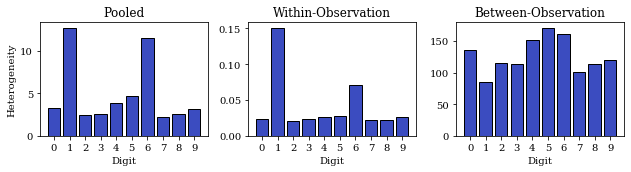

In [9]:
hetvalues = [gammas, alphas, betas]
plotlabels = [r"Pooled", r"Within-Observation", r"Between-Observation"]
fig, ax = plt.subplots(ncols=3, figsize=(9, 2.5))
ax[0].set_ylabel("Heterogeneity")
for i in range(3): 
    ax[i].set_title(plotlabels[i])
    ax[i].set_xlabel("Digit")
    ax[i].set_xticks(np.arange(10))
    ax[i].set_xticklabels(np.arange(10))
    ax[i].bar(np.arange(10), hetvalues[i], 
              facecolor=plt.get_cmap("coolwarm")(0.), 
              edgecolor="black")
plt.tight_layout()
plt.savefig("digit-class-heterogeneity.pdf", bbox_inches="tight")

We see that the 1 and 6 digit classes have the highest overall heterogeneity. This may be somewhat surprising, since the `1` class may seem relatively homogeneous. However, we will note that this may be due to the 1's being over-represented in the latent space relative to the effective number of examples (the $\beta$ heterogeneity).

### Experiment B: Leaving each class out

In [0]:
gammas = []
alphas = []
betas = []

# Compute overall heterogeneity
Xtensor = torch.Tensor(X).to(device)
mu, logvar = vae.encoder(Xtensor)
loc = mu.cpu().detach().numpy()
scale = logvar.exp().cpu().detach().numpy()
del(Xtensor); del(mu); del(logvar)
torch.cuda.empty_cache()

cov = scale_to_cov(scale)
gamma = mvn_renyi(pool_covariance(loc, cov), q=1)
alpha = mvn_renyi_alpha(cov,q=1)
beta = gamma/alpha
gammas.append(gamma)
alphas.append(alpha)
betas.append(beta)

# Now do each class left out
for i in range(10):
    digit_idx = np.logical_not(np.equal(y, i))
    Xtensor = torch.Tensor(X[digit_idx]).to(device)
    mu, logvar = vae.encoder(Xtensor)
    loc = mu.cpu().detach().numpy()
    scale = logvar.exp().cpu().detach().numpy()
    del(Xtensor); del(mu); del(logvar)
    torch.cuda.empty_cache()

    cov = scale_to_cov(scale)
    gamma = mvn_renyi(pool_covariance(loc, cov), q=1)
    alpha = mvn_renyi_alpha(cov,q=1)
    beta = gamma/alpha
    gammas.append(gamma)
    alphas.append(alpha)
    betas.append(beta)

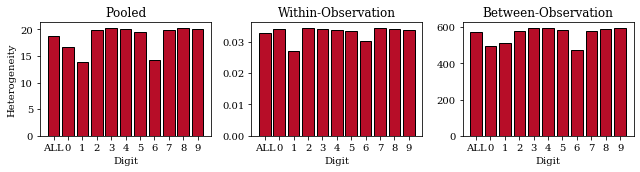

In [11]:
hetvalues = [gammas, alphas, betas]
plotlabels = [r"Pooled", r"Within-Observation", r"Between-Observation"]
fig, ax = plt.subplots(ncols=3, figsize=(9, 2.5))
ax[0].set_ylabel("Heterogeneity")
for i in range(3): 
    ax[i].set_title(plotlabels[i])
    ax[i].set_xlabel("Digit")
    ax[i].set_xticks(np.arange(11))
    ax[i].set_xticklabels(["ALL","0","1","2","3","4","5","6","7","8","9"])
    ax[i].bar(np.arange(11), hetvalues[i], 
              facecolor=plt.get_cmap("coolwarm")(0.99), 
              edgecolor="black")
plt.tight_layout()
plt.savefig("digit-class-heterogeneity-loco.pdf", bbox_inches="tight")

We notice something strange in this figure. Removing some digits, such as 0, 1, and 6 will achieve a lower $\beta$-heterogeneity than the whole dataset combined, while removing digits such as 2, 3, 4, 5, 7, 8, and 9 can keep heterogeneity the same or even increase it. 

How can the heterogeneity _increase_ when we remove data? One might begin to see the answer when we plot some maps of the 2-dimensional latent space. 

First, we show the classic filter map of the 2-D latent space of the VAE. 

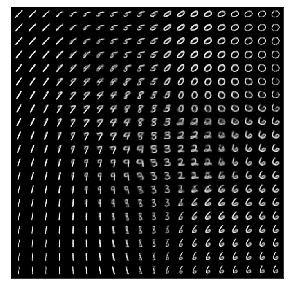

In [12]:
vae.eval()
"""https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb"""
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

bound = 2.5
nsteps = 20 
with torch.no_grad():
    latent_x = np.linspace(-bound,bound,nsteps)
    latent_y = np.linspace(-bound,bound,nsteps)
    latents = torch.FloatTensor(len(latent_x), len(latent_y), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(image_recon.data[:int(nsteps**2)],nsteps,5))
    ax.set_xticks([]); ax.set_xticklabels([])
    ax.set_yticks([]); ax.set_yticklabels([])
    plt.savefig("latent-space-map.pdf", bbox_inches="tight")

We then project the examples onto a latent space complete with $\gamma$-heterogeneity contours.

The $\gamma$-heterogeneity contours were computed by projecting each point in the latent space down into the observable space (through the decoder) then back into the latent space (through the encoder) in order to obtain that point's $\gamma$-heterogeneity.

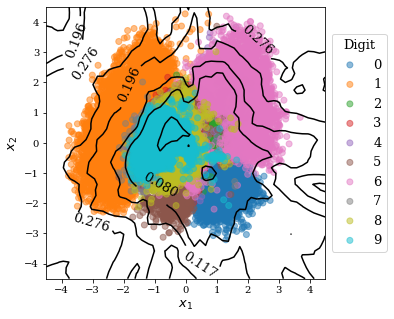

In [13]:
bound = 4.5
nsteps = 50 
with torch.no_grad():
    latent_x = np.linspace(-bound,bound,nsteps)
    latent_y = np.linspace(-bound,bound,nsteps)
    xx, yy = np.meshgrid(latent_x, latent_y)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    mu, logvar = vae.encoder(vae.decoder(latents))
    loc_ = mu.cpu().detach().numpy()
    scale_ = logvar.exp().cpu().detach().numpy()
    gamma = np.array([mvn_renyi(np.diag(cov), q=1) for cov in scale_])

    del(mu); del(logvar);  torch.cuda.empty_cache()

    # Now project the data onto the latent space for plotting 
    Xtensor = torch.Tensor(X).to(device)
    mu, logvar = vae.encoder(Xtensor)
    loc = mu.cpu().detach().numpy()
    scale = logvar.exp().cpu().detach().numpy()
    
    del(Xtensor); torch.cuda.empty_cache()

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlabel(r"$x_1$", fontsize=13)
    ax.set_ylabel(r"$x_2$", fontsize=13)
    cont = ax.contour(xx, yy, gamma.reshape(xx.shape), levels=np.percentile(gamma, np.linspace(1, 75, 5)), colors="black")
    ax.clabel(cont, fontsize=13)
    for i, digit in enumerate(np.unique(y)):
        ax.scatter(loc[y==digit,0], loc[y==digit,1], 
                   c=plt.get_cmap("tab10")(y[y==digit]), 
                   alpha=0.5, 
                   label=str(digit))
    ax.set_xlim([-bound, bound]); ax.set_ylim([-bound, bound])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0, 1, 1), fontsize=13, 
               title="Digit", title_fontsize=13)   
    plt.savefig("latent-space-gamma-heterogeneity.pdf", bbox_inches="tight")

One can appreciate that the 0, 1, and 6 classes lie at the boundaries of the latent space, and that many different classes lie in the centre of the distribution. Does the amount of heterogeneity ($\gamma, \alpha, \beta$) change across this space? To evaluate this, we performed the following steps: 

1. Projected each point in the latent space (on a 50 $\times$ 50 grid spanning the [-4, 4] box) down to the observable space (through the decoder) then back into the latent space (through the encoder) 

$$
\boldsymbol\mu_i^\prime, \boldsymbol\Sigma_i^\prime = \mathrm{Encoder}(\mathrm{Decoder}(\boldsymbol\mu_i))
$$

2. For each $\boldsymbol\mu_i^\prime$, compute the $\gamma, \alpha$, and $\beta$-heterogeneities with respect to the $K$-nearest neighbours. 

We can then show contour plots of local differences in the heterogeneity decomposition. One would expect that well-segregated classes will have higher $\alpha$-heterogeneity and lower $\beta$-heterogeneity locally. This is intuitive since different examples in a well-segregated region of latent space will be roughly indistinguishable.

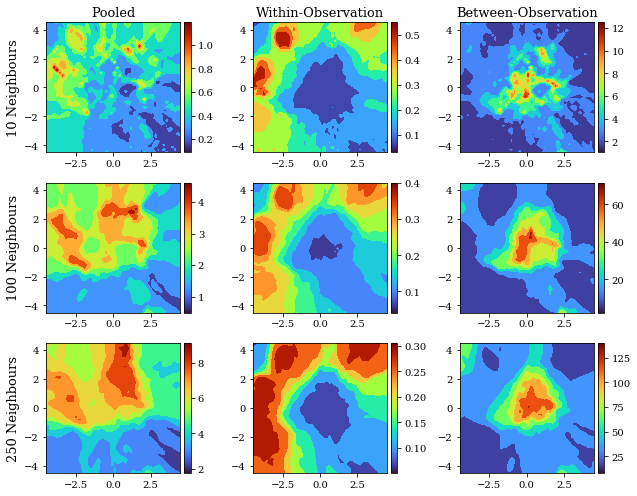

In [14]:
nneighbours = [10, 100, 250]
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(9, 7))
for i in range(3):
    skn = NearestNeighbors(n_neighbors=nneighbours[i], metric="euclidean").fit(loc_)
    _, indices = skn.kneighbors(loc_)
    gamma = np.array([mvn_renyi(pool_covariance(loc_[idx], scale_to_cov(scale_[idx])), q=1) for idx in indices])
    alpha = np.array([mvn_renyi_alpha(scale_to_cov(scale_[idx]), q=1) for idx in indices])  
    beta = gamma/alpha
    for j in range(3):
        if i == 0:
            ax[i,j].set_title(plotlabels[j], fontsize=13)
        if j == 0: 
            ax[i,j].set_ylabel("%s Neighbours" %nneighbours[i], fontsize=13)
    
    # Plot pooled
    ax[i,0].contourf(xx, yy, gamma.reshape(xx.shape), cmap="turbo")
    norm = matplotlib.colors.Normalize(vmin=np.min(gamma),vmax=np.max(gamma))
    cmap = matplotlib.cm.ScalarMappable(cmap=plt.get_cmap('turbo'), norm=norm)
    cmap.set_array([])

    divider = make_axes_locatable(ax[i,0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(cmap, ax=ax[i,0], cax=cax)    

    # Plot within
    ax[i,1].contourf(xx, yy, alpha.reshape(xx.shape), cmap="turbo")
    norm = matplotlib.colors.Normalize(vmin=np.min(alpha),vmax=np.max(alpha))
    cmap = matplotlib.cm.ScalarMappable(cmap=plt.get_cmap('turbo'), norm=norm)
    cmap.set_array([])

    divider = make_axes_locatable(ax[i,1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(cmap, ax=ax[i,1], cax=cax)

    # Plot Between
    ax[i,2].contourf(xx, yy, beta.reshape(xx.shape), cmap="turbo")
    norm = matplotlib.colors.Normalize(vmin=np.min(beta),vmax=np.max(beta))
    cmap = matplotlib.cm.ScalarMappable(cmap=plt.get_cmap('turbo'), norm=norm)
    cmap.set_array([])

    divider = make_axes_locatable(ax[i,2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(cmap, ax=ax[i,2], cax=cax)


plt.tight_layout()
plt.savefig("heterogeneity-map.pdf", bbox_inches="tight")

Indeed, this is what we see. The $\beta$-heterogeneity is highest in the centre, where most of the digits are concentrated (except 0,1,6 for the most part). In that region, the $\alpha$-heterogeneity must be small in order to distinguish examples. The corresponding $\beta$-heterogeneity must therefore be high. 

We can therefore hypothesize a reason why removing the peripheral classes reduces $\beta$-heterogeneity while removing central classes _increases_ $\beta$ or leaves it unchanged. When we remove data from the peripheries, the volume of latent space encoding distinct observations becomes highly concentrated. Conversely, when we remove a set of examples from the central aspect of the distribution, the majority of distinct observations are left in the tails, which increases the effective size of the latent space (i.e. the $\beta$ heterogeneity). We can show this using a very simple example of a Gaussian mixture with $K$ modes, arranged along a straight line. We should see that removing distributions from the centre results in an increase of $\beta$, whereas removing the extreme modes should reduce $\beta$.

In [0]:
def make_gmm(nsteps, sigma=1):
    """ Creates a GMM with distributions linearly aligned """
    nsteps = nsteps
    steps = np.linspace(0, 1, nsteps)
    means = np.stack([np.array([-2, -2]) + dt*np.array([4, 4]) for dt in steps])
    covs = sigma*np.stack([np.eye(2) for dt in steps])
    return means, covs

def remove_modes(means, covs, ncut_central=0, ncut_tail=0):
    """ Removes modes from the Gaussian mixture """
    idx = np.arange(means.shape[0])
    lower, upper = np.array_split(idx, 2)
    if ncut_central > 0:
        lower = lower[:-ncut_central]
        upper = np.flip(np.flip(upper,0)[:-ncut_central], 0)
        idx = np.hstack((lower, upper))
        means, covs = means[idx], covs[idx]
    elif ncut_tail > 0:
        upper = upper[:-ncut_tail]
        lower = np.flip(np.flip(lower,0)[:-ncut_tail], 0)
        idx = np.hstack((lower, upper))
        means, covs = means[idx], covs[idx]
    return means, covs

def renyi_gmm_test(nmodes, ncut_central=0, ncut_tail=0, sigma=1, q=1):
    """ Computes the heterogeneity for the linearly organized MVNs

    Arguments:

        nmodes: `int>1`. Number of gaussians to include (must be an even number for this script)
        ncut_central: `nmodes>int>=0`. Number of modes to remove from the center of the distribution
        ncut_tail: `nmodes>int>=0`. Number of modes to remove from the tails (default upper tail)
        sigma: `float>0`. Variance (assumed equal across all dimensions and distributions)
        q: `float>0`. Order of the heterogeneity computation

    Returns:

        gamma: `float`. 
        alpha: `float`.
        beta: `float`.
    """ 
    means, covs = make_gmm(nsteps, sigma)
    means, covs = remove_modes(means, covs, ncut_central, ncut_tail)
    gamma = mvn_renyi(pool_covariance(means, covs), q)
    alpha = mvn_renyi_alpha(covs, q)
    beta = gamma/alpha
    return gamma, alpha, beta 


First, we provide an illustration of what this experiment does. Essentially, we have a system of $K$ distributions where 2 are at the tails, and the remaining $K-2$ are located at points that are linear interpolates of the poles. We then measure the heterogeneity ($\gamma, \alpha, \beta$) each time we remove one of the modes. We remove the modes under two conditions:

1. Removing modes that are somewhere inbetween the two tails
2. Removing means from the two tails

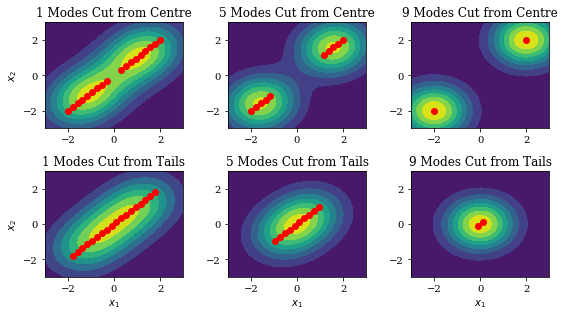

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 4.5))
ls = np.linspace(-3, 3, 50)
XX, YY = np.meshgrid(ls, ls)
Xflat = np.hstack((XX.reshape(-1, 1), YY.reshape(-1, 1)))

for j, ntocut in enumerate([1, 5, 9]):
    means, covs = make_gmm(20)
    means, covs = remove_modes(means, covs, ncut_central=ntocut)
    Z = np.sum([ss.multivariate_normal(means[i], covs[i]).pdf(Xflat) for i in range(means.shape[0])], axis=0)
    ax[0, j].contourf(XX, YY, Z.reshape(XX.shape))
    ax[0, j].scatter(means[:,0], means[:,1], c="r")

    means, covs = make_gmm(20)
    means, covs = remove_modes(means, covs, ncut_tail=ntocut)
    Z = np.sum([ss.multivariate_normal(means[i], covs[i]).pdf(Xflat) for i in range(means.shape[0])], axis=0)
    ax[1, j].contourf(XX, YY, Z.reshape(XX.shape))
    ax[1, j].scatter(means[:,0], means[:,1], c="r")

    ax[0,j].set_title("%s Modes Cut from Centre" %ntocut)
    ax[1,j].set_title("%s Modes Cut from Tails" %ntocut)
    ax[1,j].set_xlabel(r"$x_1$")
    if j == 0:
        ax[0,j].set_ylabel(r"$x_2$")
        ax[1,j].set_ylabel(r"$x_2$")
    
plt.tight_layout()
plt.savefig("mode-pruning-illustration.pdf", bbox_inches="tight")

We now plot the heterogeneity values across mode cutting strategies.

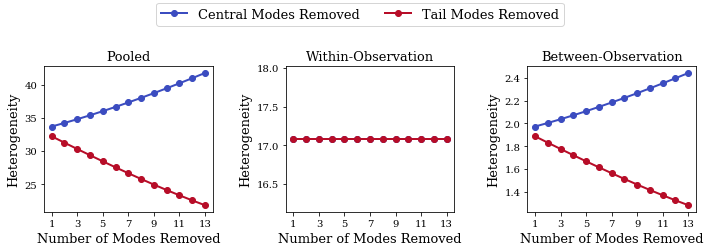

In [17]:
nmodes = 30
ncut = np.arange(1, int(nmodes/2 - 1))
res_central = np.stack([renyi_gmm_test(nmodes, n) for n in ncut])
res_tail = np.stack([renyi_gmm_test(nmodes, 0, n) for n in ncut])
fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
for j in range(3):
    ax[j].set_title(plotlabels[j], fontsize=13)
    ax[j].set_xlabel("Number of Modes Removed", fontsize=13)
    ax[j].set_xticks(ncut[::2]); ax[j].set_xticklabels(ncut[::2])
    ax[j].set_ylabel("Heterogeneity", fontsize=13)
    
    # If-then statement here is just to avoid repeating legend labels
    if j == 2:
        ax[j].plot(ncut, res_central[:,j], lw=2, c=plt.get_cmap("coolwarm")(0),
                marker="o", label="Central Modes Removed")
        ax[j].plot(ncut, res_tail[:,j], lw=2, c=plt.get_cmap("coolwarm")(0.99),
                marker="o", label="Tail Modes Removed")
    else: 
        ax[j].plot(ncut, res_central[:,j], lw=2, c=plt.get_cmap("coolwarm")(0),
                marker="o")
        ax[j].plot(ncut, res_tail[:,j], lw=2, c=plt.get_cmap("coolwarm")(0.99),
                marker="o")
fig.legend(loc="center", bbox_to_anchor=(0.5, 1.1), ncol=2, fontsize=13)
plt.tight_layout()
plt.savefig("mode-removal-beta-heterogeneity.pdf", bbox_inches="tight")

Indeed, as expected, removing central modes will increase $\beta$-heterogeneity, while removing tail modes will reduce $\beta$.

We can also see that removing modes never changes $\alpha$-heterogeneity, since that is the average heterogeneity within a mode's distribution. Since all the modes have distributions with the same covariance, this predictably does not change.

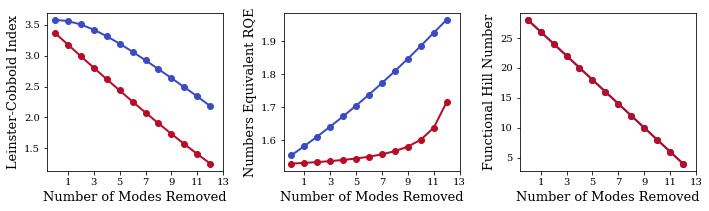

In [18]:
from sklearn.metrics import pairwise_distances
nmodes = 30
ncut = np.arange(1, int(nmodes/2 - 1))

LCI = []
Qe = []
FHN = []
for i in ncut:
    means, covs = make_gmm(nmodes)
    means, covs = remove_modes(means, covs, ncut_central=i, ncut_tail=0)
    D = pairwise_distances(means)
    p = np.repeat(1/means.shape[0], means.shape[0])
    lci_central = div.leinster_cobbold(np.exp(-D), p)
    Qe_central = div.ricotta_szeidl(D, p)
    fhn_central = div.func_hill(D, p)

    means, covs = make_gmm(nmodes)
    means, covs = remove_modes(means, covs, ncut_central=0, ncut_tail=i)
    D = pairwise_distances(means)
    p = np.repeat(1/means.shape[0], means.shape[0])
    lci_tail = div.leinster_cobbold(np.exp(-D), p)
    Qe_tail = div.ricotta_szeidl(D, p)
    fhn_tail = div.func_hill(D, p)

    LCI.append([lci_central, lci_tail])
    Qe.append([Qe_central, Qe_tail])
    FHN.append([fhn_central, fhn_tail])

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].plot(np.array(LCI)[:,0], marker='o', lw=2, c=plt.get_cmap("coolwarm")(0))
ax[1].plot(np.array(Qe)[:,0], marker='o', lw=2, c=plt.get_cmap("coolwarm")(0))
ax[2].plot(np.array(FHN)[:,0], marker='o', lw=2, 
           c=plt.get_cmap("coolwarm")(0), label="Central Modes Removed")

ax[0].plot(np.array(LCI)[:,1], marker='o', lw=2, c=plt.get_cmap("coolwarm")(0.99))
ax[1].plot(np.array(Qe)[:,1], marker='o', lw=2, c=plt.get_cmap("coolwarm")(0.99))
ax[2].plot(np.array(FHN)[:,1], marker='o', lw=2, 
           c=plt.get_cmap("coolwarm")(0.99), label="Tail Modes Removed")

ax[0].set_ylabel("Leinster-Cobbold Index", fontsize=13)
ax[1].set_ylabel("Numbers Equivalent RQE", fontsize=13)
ax[2].set_ylabel("Functional Hill Number", fontsize=13)

for i in range(3):
    ax[i].set_xticks(ncut[::2])
    ax[i].set_xticklabels(ncut[::2])
    ax[i].set_xlabel("Number of Modes Removed", fontsize=13)

#fig.legend(loc="center", bbox_to_anchor=(0.5, 1.1), ncol=2, fontsize=13)
plt.tight_layout()
plt.savefig("classic-index-mode-pruning.pdf", bbox_inches="tight")

## Does $\beta$-heterogeneity in this context really capture heterogeneity?

The purpose of this aspect of our experiment is to verify (visually) that data sampled from spots with high $\beta$-heterogeneity will be more diverse in their contents. 

For each block of 49 points in the latent space, we reconstructed images, and then projected those images back into the latent space, where we computed the heterogeneity ($\alpha, \beta, \gamma$). We then plotted the image samples from the regions of latent space with the highest and lowest $\beta$-heterogeneity, respectively. 

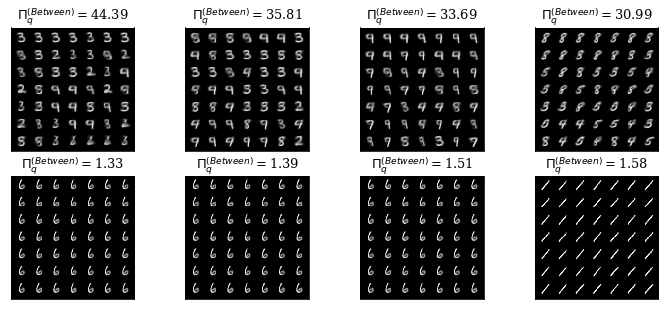

In [19]:
skn = NearestNeighbors(n_neighbors=49, metric="euclidean").fit(loc_)
_, indices = skn.kneighbors(loc_)
gamma = np.array([mvn_renyi(pool_covariance(loc_[idx], scale_to_cov(scale_[idx])), q=1) for idx in indices])
alpha = np.array([mvn_renyi_alpha(scale_to_cov(scale_[idx]), q=1) for idx in indices])  
beta = gamma/alpha

nsamples = 4
fig, ax = plt.subplots(nrows=2, ncols=nsamples, figsize=(12, 5))
beta_sorted_idx = np.argsort(beta)
for i in range(nsamples):
    max_idx = indices[beta_sorted_idx[-(20*i+1)]]
    min_idx = indices[beta_sorted_idx[20*i]]
    
    # Highest beta heterogeneity samples
    Ztensor = torch.Tensor(loc_[max_idx]).to(device)
    images = vae.decoder(Ztensor)
    del(Ztensor); torch.cuda.empty_cache()
    images = images.cpu()
    images = to_img(images)
    np_imagegrid = torchvision.utils.make_grid(images, 7, 7).detach().numpy()
    ax[0,i].set_title(r"$\Pi_q^{(Between)}=$%0.2f" %beta[beta_sorted_idx[-(20*i+1)]], fontsize=13)
    ax[0,i].imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    ax[0,i].set_xticks([]); ax[0,i].set_xticklabels([])
    ax[0,i].set_yticks([]); ax[0,i].set_yticklabels([])

    # Lowest beta heterogeneity samples
    Ztensor = torch.Tensor(loc_[min_idx]).to(device)
    images = vae.decoder(Ztensor)
    del(Ztensor); torch.cuda.empty_cache()
    images = images.cpu()
    images = to_img(images)
    np_imagegrid = torchvision.utils.make_grid(images, 7, 7).detach().numpy()
    ax[1,i].set_title(r"$\Pi_q^{(Between)}=$%0.2f" %beta[beta_sorted_idx[20*i]], fontsize=13)
    ax[1,i].imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    ax[1,i].set_xticks([]); ax[1,i].set_xticklabels([])
    ax[1,i].set_yticks([]); ax[1,i].set_yticklabels([])
plt.savefig("beta-heterogeneity-samples.pdf", bbox_inches="tight")

These plots provide visual verification that the $\beta$-heterogeneity is related to the sample diversity, since patches in the latent space that have higher $\beta$-heterogeneity will tend to map onto more diverse samples. 